# Matflow Crystal Plasticity Modelling diffraction post-processing examples

This notebook is intended as a walkthrough for use of digital x-ray analysis of simualted volume elements from crystal plastcity models.
Follow the steps described to produce detailed analysis of crystal plasticity model results for comparison/validation against experimental X-ray diffraction analysis, or for a better description of your model predictions.

In [1]:
# Firstly, load in the required python libraries and functions:
# libraries and functions from the web:
import numpy as np
from matflow import load_workflow
import pickle
from cycler import cycler
import matplotlib.pyplot as plt
# libraries and functions local to this repository:
from utils import import_diff_params
from lattice_strain import VE_phase_mask
from lattice_strain import lattice_strain
from plotting import plot_latticestrain
from plotting import plot_truestrain_peakint
from plotting import plot_lattice_strain_dist_inc


Specify the workflow and therefore simulation results you would like to post-process by changing the path string of the `workflow_dir` variable in the cell below. This should point to the directory containing the `workflow.hdf5` file where the matflow simulation results have been saved following a successfully run matflow-damask workflow.

The runtime of this cell depends on the size of the `workflow.hdf5` file contained within your workflow directory.
**20Gbs can take up to 2mins to load**.

In [3]:

# define path to completed matflow workflow directory containing result.hdf5 file...
workflow_dir = "/mnt/iusers01/jf01/y15576gb/\
postprocessing/\
034_Ti64_TIFUN-T4_TD_910C_DeformY64x_1mms-1_2023-03-14-113312/"

# use load_workflow to import the result.hdf5 file into jupyter as a variable...
workflow = load_workflow(workflow_dir)
ve_response = workflow.tasks.simulate_volume_element_loading.elements[0].outputs.volume_element_response


---
## Plotting Stress-strain of a matflow-DAMASK simulation.
The following code takes a matflow workflow's `workflow.hdf5` file and plots stress against strain.

Required arguments in `workflow.yaml`:
```yaml
  - name: simulate_volume_element_loading
    method: CP_FFT
    software: DAMASK
    output_map_options:
      operations:
        - name: add_stress_Cauchy
          args: { P: P, F: F }
        - name: add_strain
          args: { F: F, t: V, m: 0 }
          opts: { add_Mises: true }

      volume_data: # For global stress-strain
        - field_name: sigma
          transforms: [mean_along_axes: 1] # mean over VE
          out_name: sigma
        - field_name: epsilon_V^0(F)_vM
          transforms: [mean_along_axes: 1] # mean over VE 
          out_name: epsilon_V^0(F)_vM

    base:
      phases:
        phase_1:
          mechanical:
            output: [F, F_e, F_p, P, L_p]
```

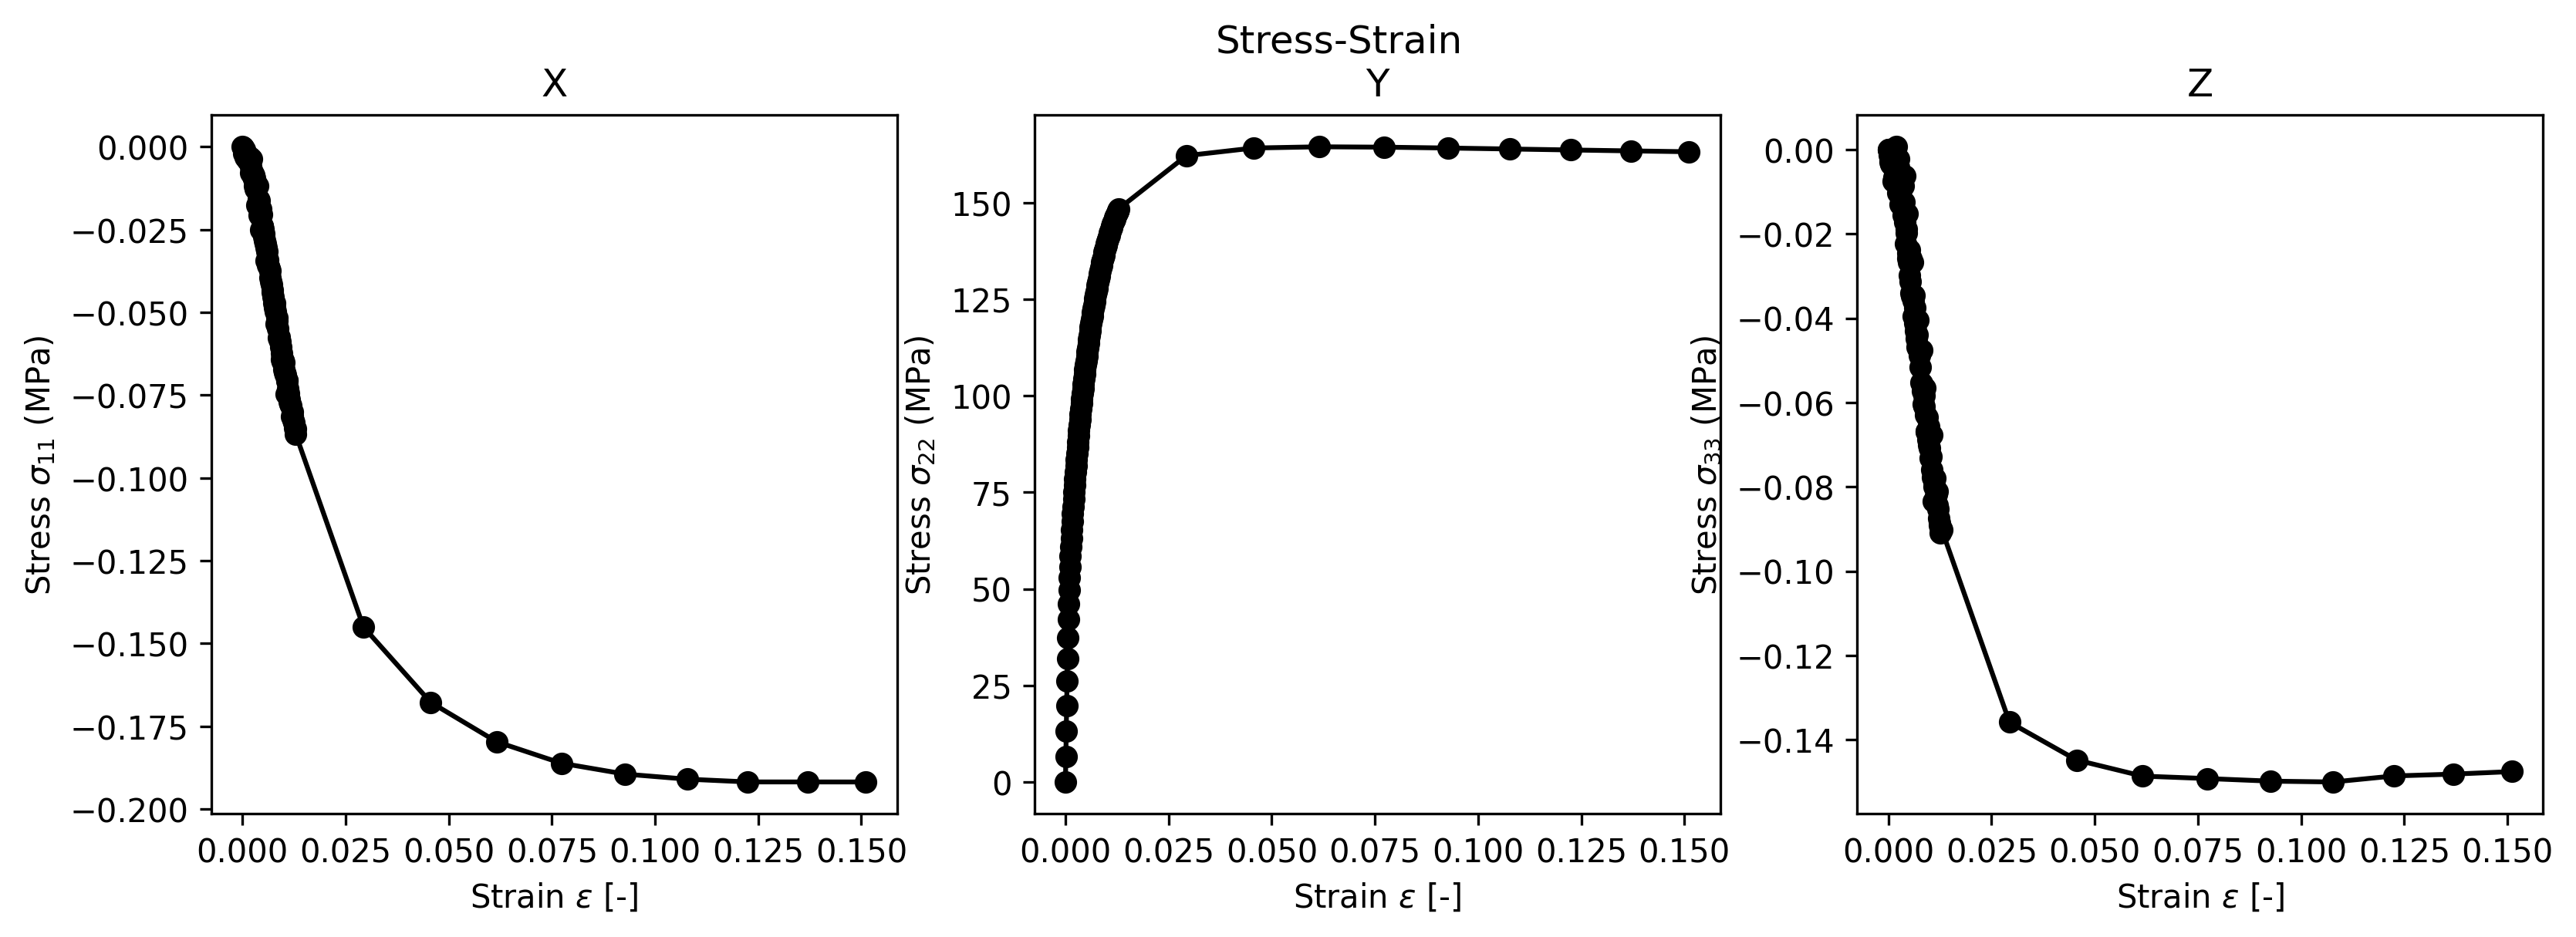

In [4]:
%matplotlib inline

fig, axs = plt.subplots(1,3, figsize=(13, 4), dpi=300, facecolor='w')
fig.suptitle('Stress-Strain')

for i, axis in enumerate(["X", "Y", "Z"]): # loop over axes directions
    stress_strain = {'stress' : ve_response["volume_data"]["sigma"]["data"][:, i, i]/1e6, # MPa
                     'strain' : ve_response["volume_data"]["epsilon_V^0(F)_vM"]["data"]}

    axs[i].plot(stress_strain['strain'], stress_strain['stress'], linestyle='solid', marker='o', color="k")
    axs[i].title.set_text(f"{axis}")
    axs[i].set_facecolor("white")
    axs[i].set_xlabel(f"Strain $\epsilon$ [-]")
    axs[i].set_ylabel(f"Stress $\sigma_{{{str(i+1)}{str(i+1)}}}$ (MPa)")
    
# save stress_strain dict as .pkl file to avoid reloading workflow.hdf5 file:
pickle.dump(stress_strain, open(workflow_dir+'stress_strain.pkl', 'wb'))

---
## Calculate lattice strain from a matflow-DAMASK workflow
The following code takes a matflow workflow's `workflow.hdf5` file and plots true stress against lattice strain for each crystallographic plane.

Required arguments in `workflow.yaml`:
```yaml
  - name: simulate_volume_element_loading
    method: CP_FFT
    software: DAMASK
    output_map_options:
      operations:
        - name: add_stress_Cauchy
          args: { P: P, F: F }
        - name: add_strain
          args: { F: F, t: V, m: 0 }
          opts: { add_Mises: true }

      volume_data: # For global stress-strain
        - field_name: sigma
          transforms: [mean_along_axes: 1] # mean over VE
          out_name: sigma
        - field_name: epsilon_V^0(F)_vM
          transforms: [mean_along_axes: 1] # mean over VE 
          out_name: epsilon_V^0(F)_vM
            
      field_data: # for lattice strain
        - field_name: phase
        - field_name: epsilon_V^2(F_e) # left elastic strain tensor
        - field_name: epsilon_U^2(F_e) # right elastic strain tensor
        - field_name: F_p # plastic deformation gradient tensor
        - field_name: O # orientations as quaternions

    base:
      phases:
        phase_1:
          mechanical:
            output: [F, F_e, F_p, P, L_p, O]
```

Step-by-step:
1. Import crystallographic parameters from crystallographic_params.yaml file.
2. Get unit vector describing the measurement direction given axis as string with function eg. "X" into "[1, 0, 0]"
3. Check for diffraction using tolerance of $5^o$ of satisfying Bragg condition.
4. Read lattice strains for these material points and add to bin for lattice plane label.
5. Plot lattice strains of each plane against true stress of the volume element.

Warning: This can take between up to 2hrs to compute for a $128^3$ volume element with $100$ loading steps.
**This is only required once.** Calculated data is saved to the workflow directory defined so that plot features can be changed quickly.

In [ ]:

phases = import_diff_params("Ti_alpha", "Ti_beta")

phase_idx, phase_mask = VE_phase_mask(phases, ve_response)

# Using left Cauchy-Green defomation tensor for elastic strain...
Ee = ve_response['field_data']['epsilon_V^2(F_e)']['data'][:, phase_mask, :, :]  ; print(Ee.shape)
Ee_incs = ve_response['field_data']['epsilon_V^2(F_e)']['meta']['increments']

# get number of increments...
oris = ve_response['field_data']['O']['data']
ori_incs = ve_response['field_data']['O']['meta']['increments']

latticestrain={}
plane_intensity={}
for axis in ["X", "Y", "Z"]: # plot subsequent plots for every axis direction

    # calculate lattice strains and count material points with that lattice strain
    latticestrain[axis], plane_intensity[axis] = lattice_strain(Ee, Ee_incs, oris, ori_incs, phase_idx, phase_mask, phases, axis)
    
# save data to .pkl files to avoid having to recalculate to change the graphs.
with open(workflow_dir+'lattice_strain.pkl', 'wb') as ls:
    pickle.dump(latticestrain, ls)
with open(workflow_dir+'plane_intensity.pkl', 'wb') as pi:
    pickle.dump(plane_intensity, pi)

---
## plot true stress against lattice strain

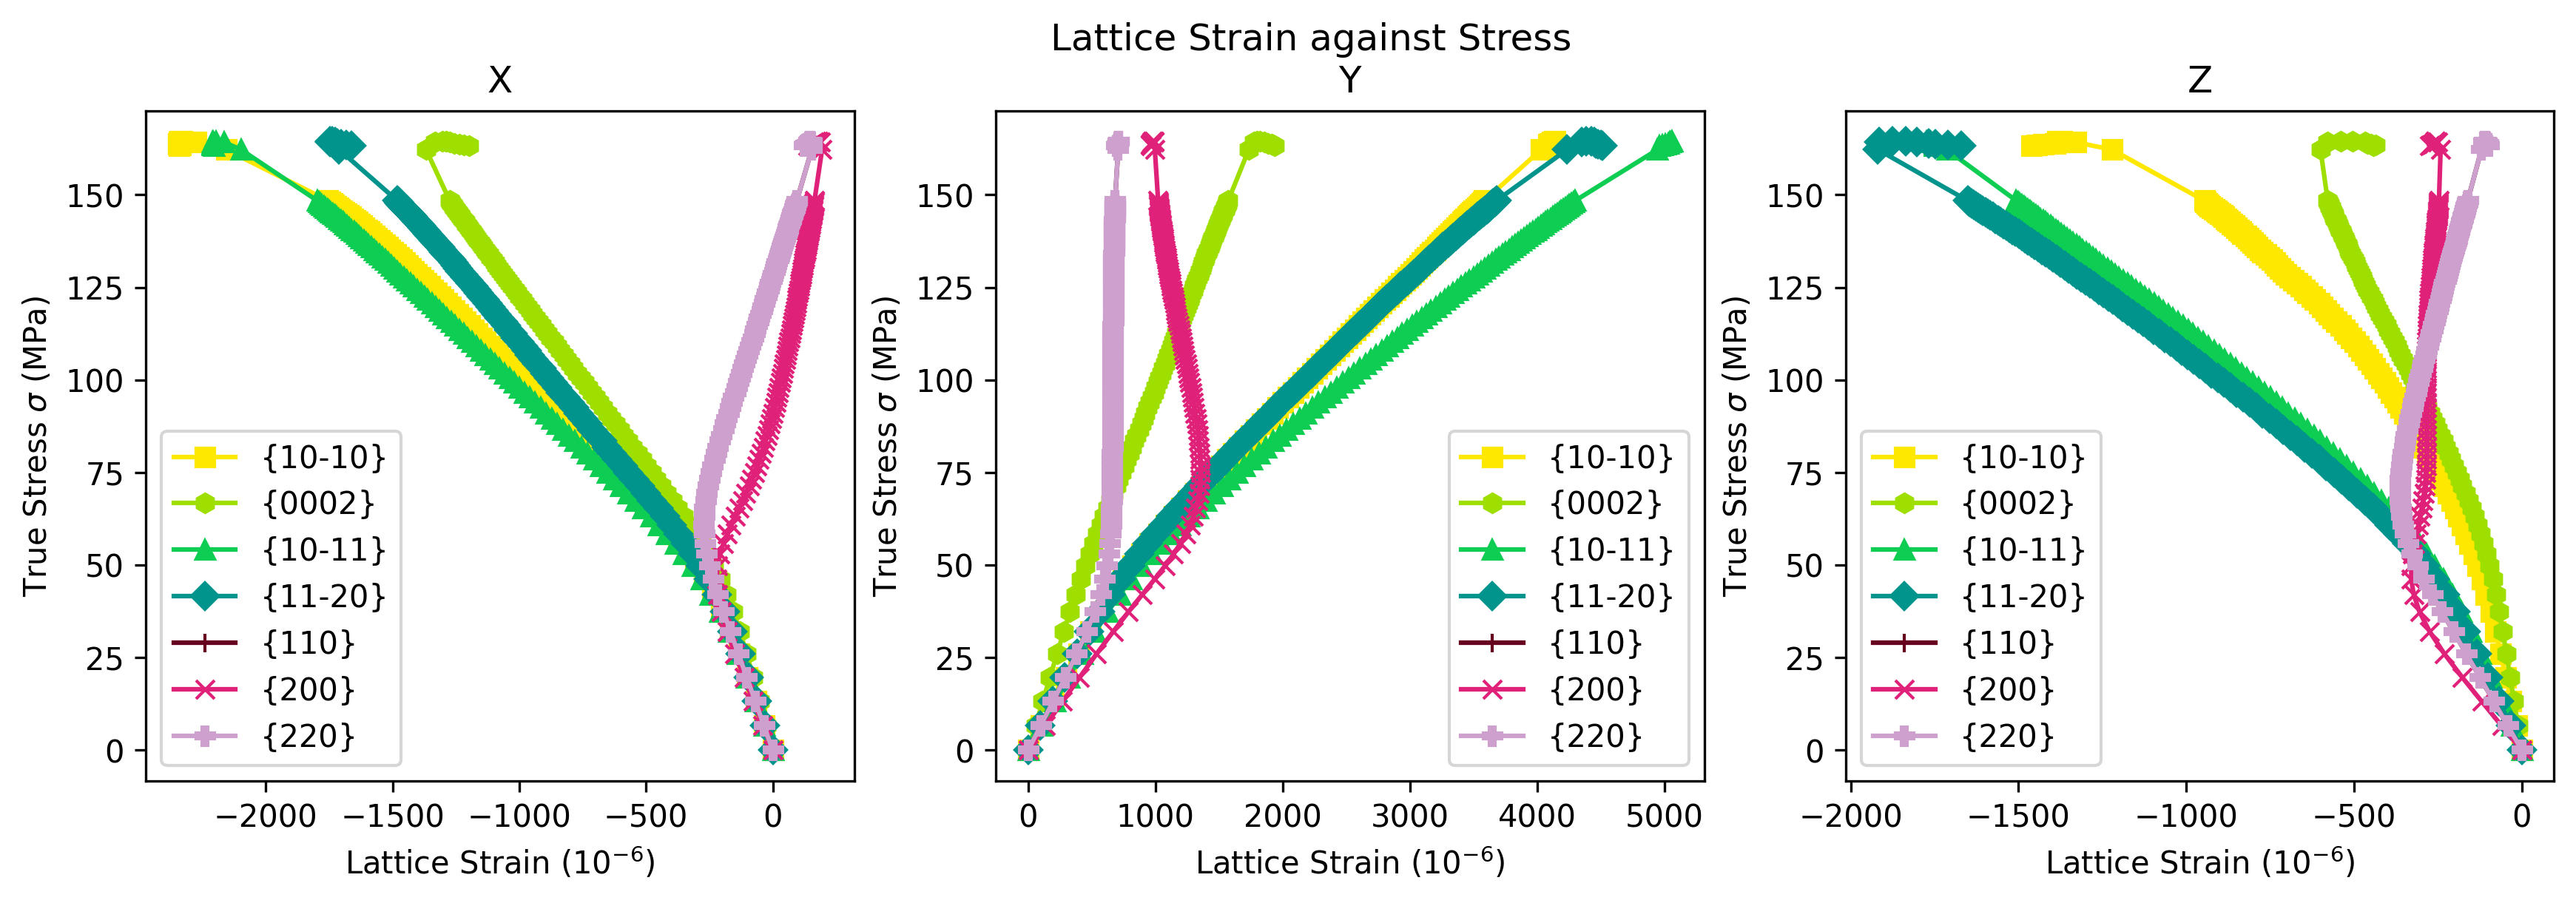

In [5]:
%matplotlib inline

true_stress = ve_response['volume_data']['sigma']['data'][:,1, 1]/1e6 # this is for Y axis. X would be [0, 0]
latticestrain = pickle.load(open(workflow_dir+'lattice_strain.pkl', 'rb'))

fig, axs = plt.subplots(1,3, figsize=(14, 4), dpi=300) # one row, three coloumns
fig.suptitle('Lattice Strain against Stress')
for i, axis in enumerate(["X", "Y", "Z"]):
    plot_latticestrain(axs[i], true_stress, latticestrain, axis, incs="*", xlim=None, ylim=None)


## plot plane intensity against true strain

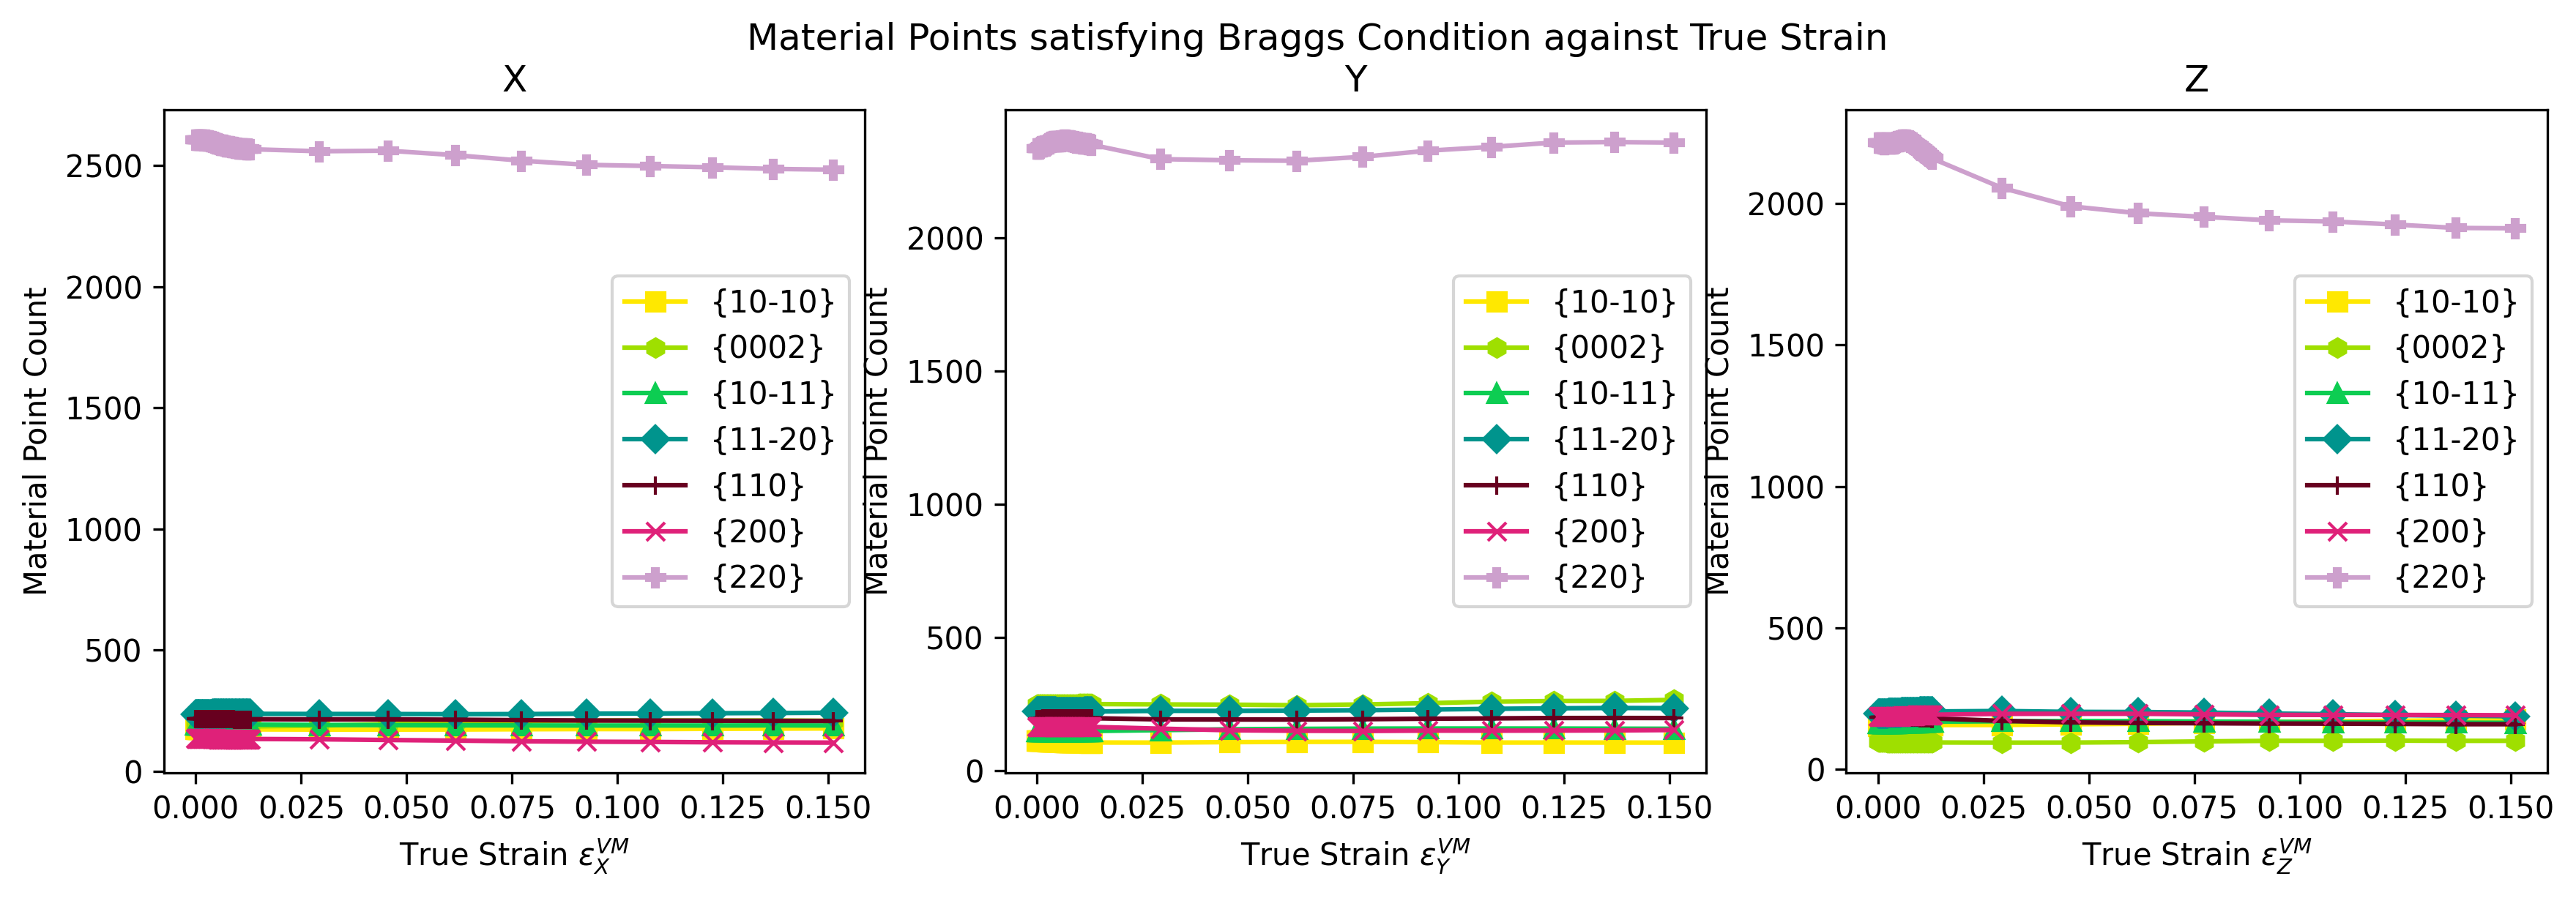

In [7]:
%matplotlib inline

phases = import_diff_params("Ti_alpha", "Ti_beta")

true_strain = ve_response['volume_data']['epsilon_V^0(F)_vM']['data']
plane_intensity = pickle.load(open(workflow_dir+'plane_intensity.pkl', 'rb'))

fig, axs = plt.subplots(1,3, figsize=(14, 4), dpi=300) # one row, three coloumns
fig.suptitle(f"Material Points satisfying Braggs Condition against True Strain")
for i, axis in enumerate(["X", "Y", "Z"]):
    plot_truestrain_peakint(axs[i], plane_intensity, true_strain, axis, phases.keys(), xlim=None, ylim=None)


## plot distrubution of lattice strain

phase: Ti_beta Direction: X
	plane: {110}	lattice strain 
	plane: {200}	lattice strain 
phase: Ti_beta Direction: Y
	plane: {110}	lattice strain 
	plane: {200}	lattice strain 
phase: Ti_beta Direction: Z
	plane: {110}	lattice strain 
	plane: {200}	lattice strain 


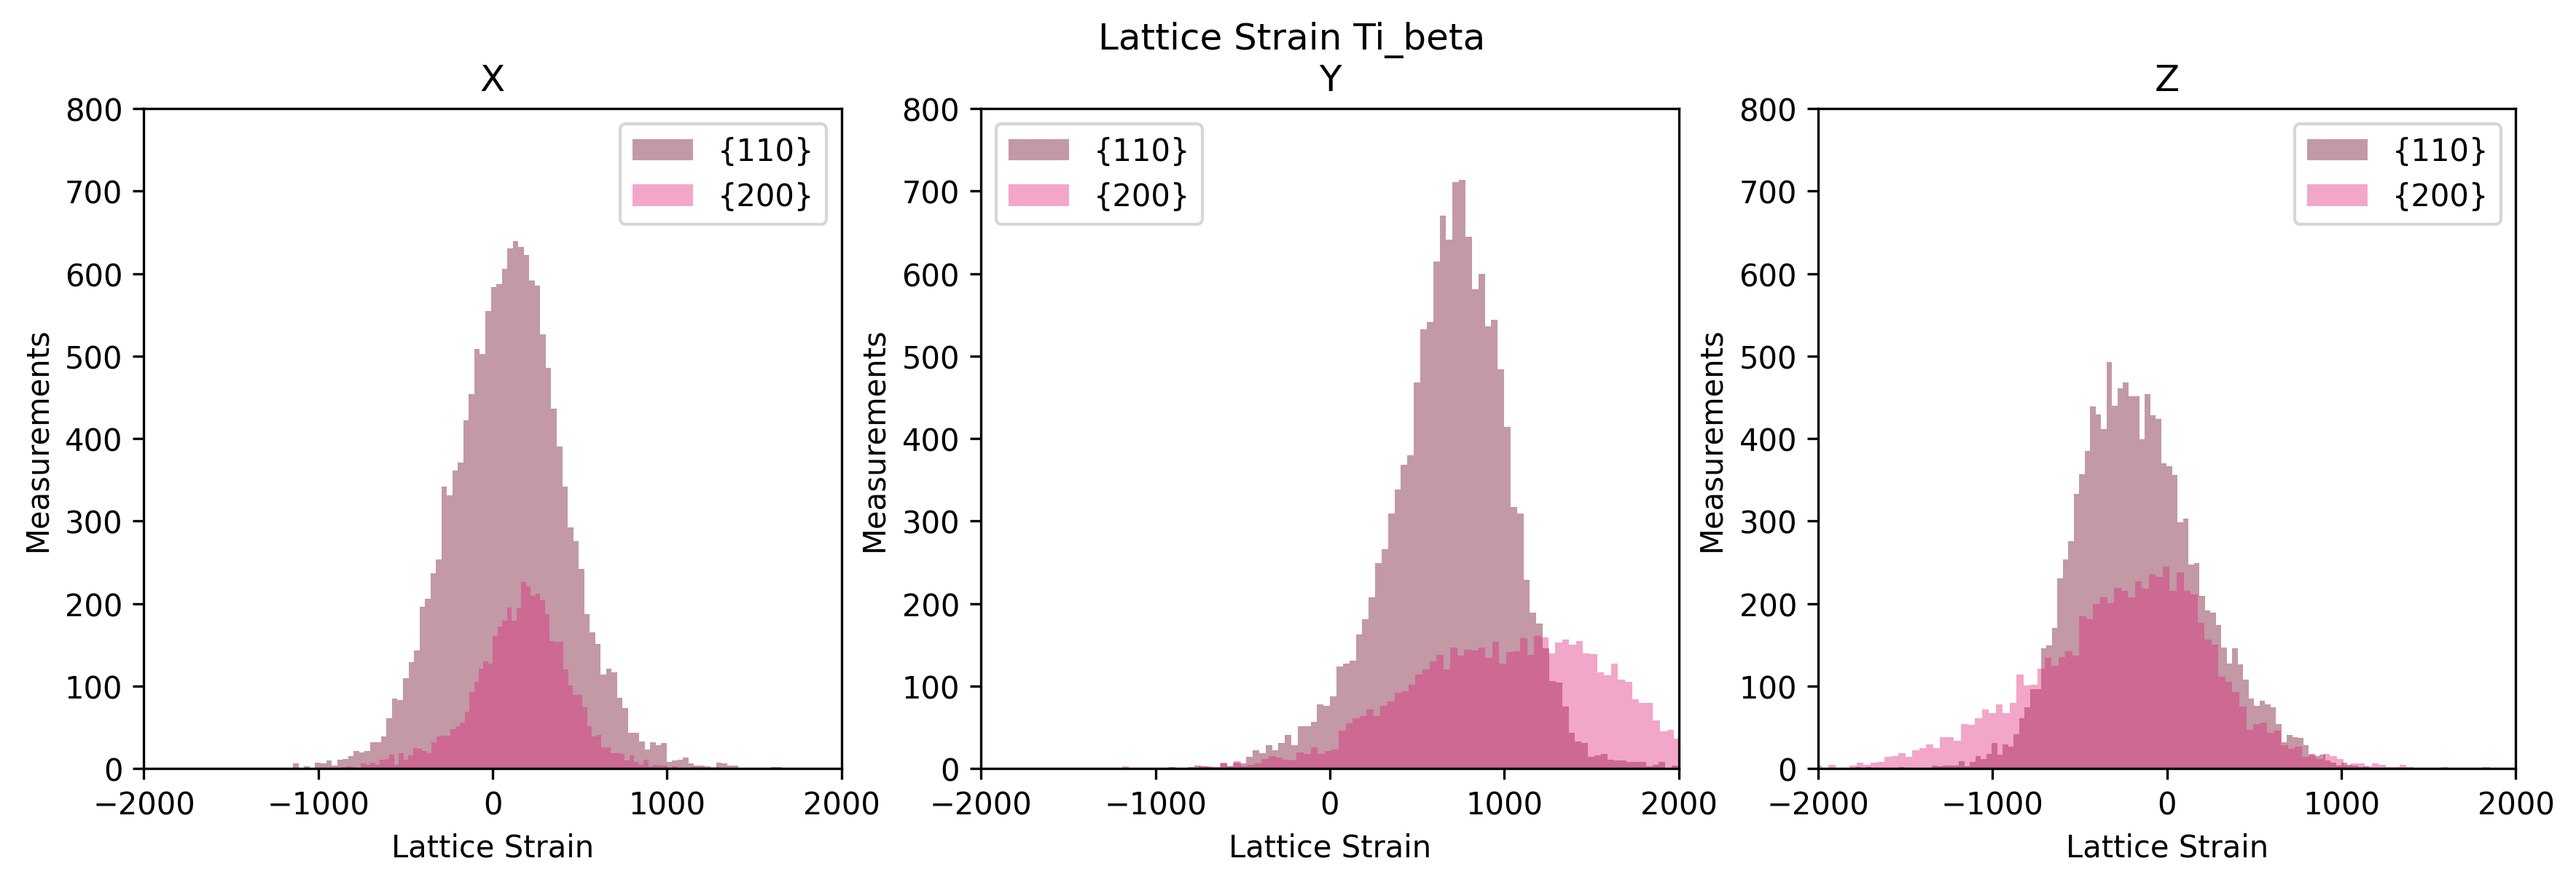

In [9]:
%matplotlib inline

latticestrain = pickle.load(open(workflow_dir+'lattice_strain.pkl', 'rb'))

fig, axs = plt.subplots(1,3, figsize=(14, 4), dpi=300) # one row, three coloumns
fig.suptitle(f"Lattice Strain Ti_beta")
for i, axis in enumerate(["X", "Y", "Z"]):
    plot_lattice_strain_dist_inc(axs[i], latticestrain, axis,
                                 phase="Ti_beta", inc=100, bins=100,
                                 xmin=-2000, xlim=2000,
                                 ymin=0, ylim=800)


## plot hydrostatic stress against true strain

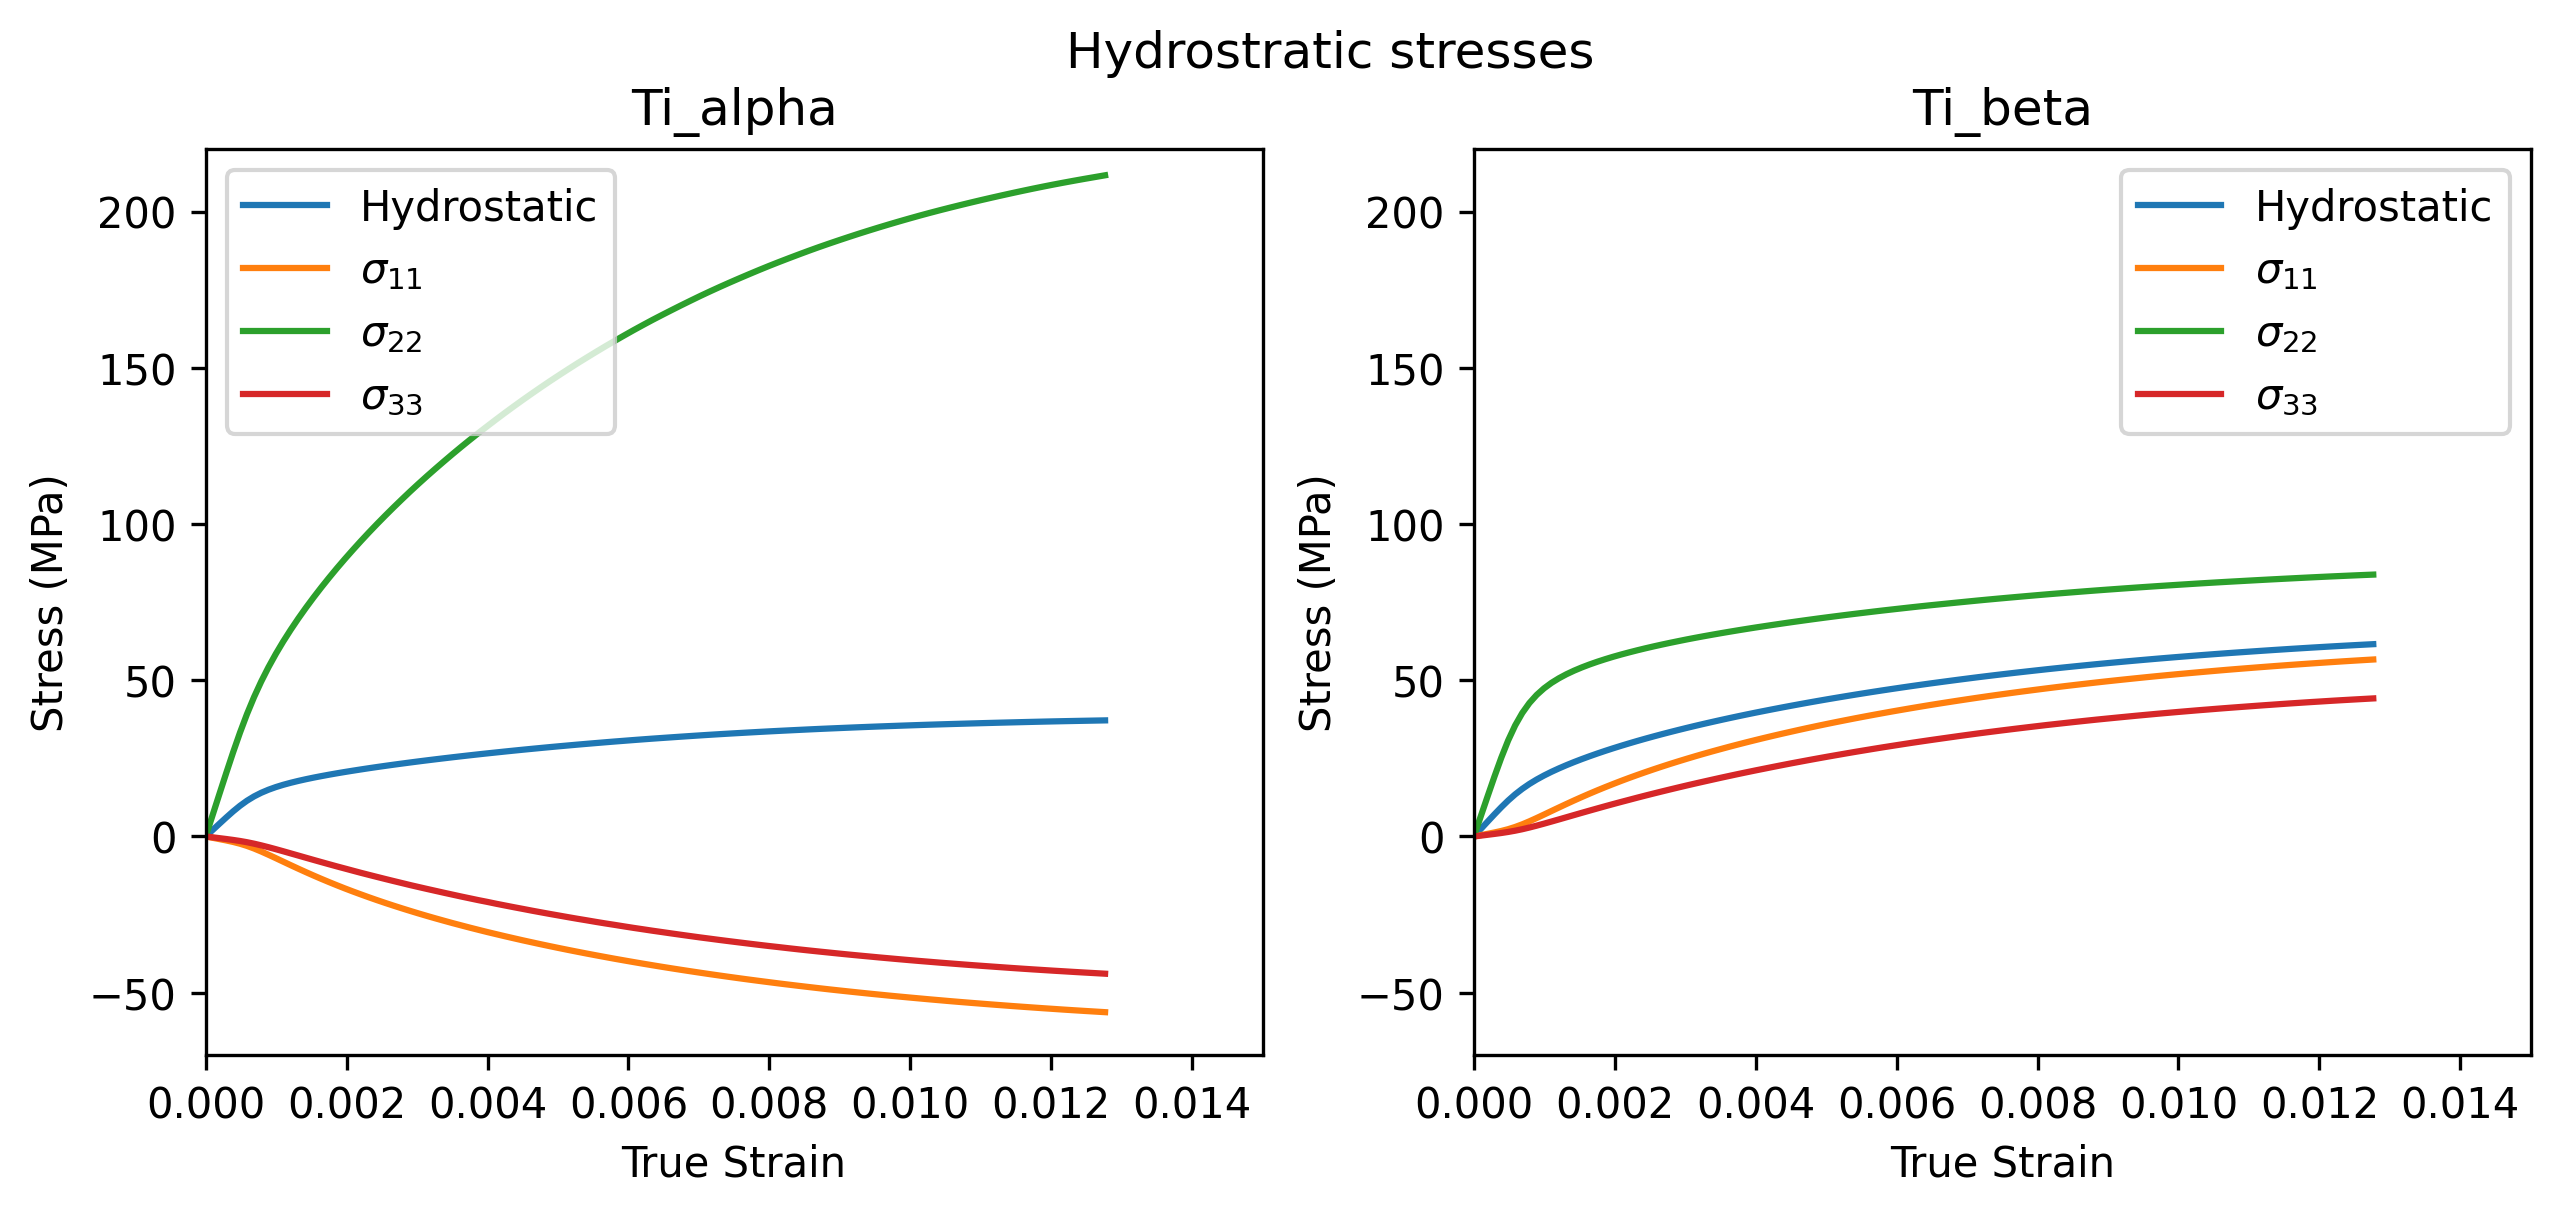

In [10]:
import numpy as np
import matplotlib.pyplot as plt
## plot hydrostatic strain with engineering strain

phases = ["Ti_alpha", "Ti_beta"]
phase="Ti_beta"
ve_response = workflow.tasks.simulate_volume_element_loading.elements[0].outputs.volume_element_response
total_incs=range(0,100)
xmin, xlim = 0, 0.015
ymin, ylim = -70, 220

fig, axs = plt.subplots(1,2, figsize=(10, 4), dpi=300) # one row, three coloumns
fig.suptitle('Hydrostratic stresses')

for i, phase in enumerate(phases):
    true_strain = []
    sigma_X = []
    sigma_Y = []
    sigma_Z = []
    triaxial_stress = []

    # calculate hydrostatic stress from tensor components
    for inc in range(0, 100):
        true_strain.append(ve_response["volume_data"]['epsilon_V^0(F)_vM']['data'][inc])
        sigma_X.append( ve_response["phase_data"][phase+'_sigma']['data'][inc,:,0,0].mean(axis=0)/1e6 )
        sigma_Y.append( ve_response["phase_data"][phase+'_sigma']['data'][inc,:,1,1].mean(axis=0)/1e6 )
        sigma_Z.append( ve_response["phase_data"][phase+'_sigma']['data'][inc,:,2,2].mean(axis=0)/1e6 )
        triaxial_stress.append( (sigma_X[inc] + sigma_Y[inc] + sigma_Z[inc])/3 )
    axs[i].plot(true_strain, triaxial_stress, label="Hydrostatic")
    axs[i].plot(true_strain, sigma_X, label="$\sigma_{11}$")
    axs[i].plot(true_strain, sigma_Y, label="$\sigma_{22}$")
    axs[i].plot(true_strain, sigma_Z, label="$\sigma_{33}$")
    axs[i].set_title(f"{phase}")
    axs[i].set_xlabel("True Strain")
    axs[i].set_xlim(xmin, xlim)
    axs[i].set_ylabel("Stress (MPa)")
    axs[i].set_ylim(ymin, ylim)
    axs[i].legend()

## Plot plane-masked stress against true strain

In [ ]:

phases = import_diff_params("Ti_alpha", "Ti_beta")

# Using left Cauchy-Green defomation tensor for elastic strain...
stress = ve_response['phase_data']['Ti_alpha_sigma']['data']
stress_incs = ve_response['volume_data']['sigma']['meta']['increments']

# get number of increments...
oris = ve_response['field_data']['O']['data']
ori_incs = ve_response['field_data']['O']['meta']['increments']

stress_diffraction={}
plane_intensity={}
for axis in ["X", "Y", "Z"]: # plot subsequent plots for every axis direction

    for phase_name, phase in phases.items():
        phase_idx, phase_mask = VE_phase_mask(phase_name, ve_response)
    
        # calculate lattice strains and count material points with that lattice strain
        stress_diffraction[axis], plane_intensity[axis] = lattice_strain(stress, stress_incs, oris, ori_incs, phase_idx, phase_mask, phases, axis)
    
# save data to .pkl files to avoid having to recalculate to change the graphs.
with open(workflow_dir+'stress_diffraction.pkl', 'wb') as sd:
    pickle.dump(stress_diffraction, sd)
with open(workflow_dir+'plane_intensity.pkl', 'wb') as pi:
    pickle.dump(plane_intensity, pi)


phase_data 'Ti_alpha_sigma' stress.shape: (110, 131751, 3, 3)
field_data oris.shape: (110, 64, 64, 64, 4)
Processing phase Ti_alpha in X direction...
Processing plane {10-10}...
Processing plane {0002}...
Processing plane {10-11}...
Processing plane {11-20}...
Processing phase Ti_beta in X direction...
Processing plane {110}...
Processing plane {200}...


In [ ]:
%matplotlib inline

true_strain = ve_response['volume_data']['epsilon_V^0(F)_vM']['data'][:,1, 1]/1e6 # this is for Y axis. X would be [0, 0]
stress_diffraction = pickle.load(open(workflow_dir+'stress_diffraction.pkl', 'rb'))

fig, axs = plt.subplots(1,3, figsize=(14, 4), dpi=300) # one row, three coloumns
fig.suptitle('Diffracted stress against Strain')
for i, axis in enumerate(["X", "Y", "Z"]):
    plot_latticestrain(axs[i], stress_diffraction, true_strain, axis, incs="*", xlim=None, ylim=None)